## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
"""
建立神經網路，並加入 L1 或 L2 或 L1_L2
"""
def build_mlp_Lx(input_shape, output_units=10, num_neurons=[512, 256, 128], regularizers_function="L2" ,ratios=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    if regularizers_function == "L1":
        regularizers = l1(ratios)
    elif regularizers_function == "L2":
        regularizers = l2(ratios)
    else:
        regularizers = l1_l2(ratios)
        
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regularizers)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regularizers)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
from keras.layers import Dropout
"""
建立神經網路，並加入 Dropout
"""
def build_mlp_Dropout(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BatchNormalization
"""
def build_mlp_BN(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
"""
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

regularizations = [ "L1 or L2 or L1_L2", "Dropout", "BatchNormalization"]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizers in regularizations:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    print("Experiment with Regulizers = %s" % regulizers )
    
    if regulizers == "L1 or L2 or L1_L2":
        model = build_mlp_Lx(input_shape=x_train.shape[1:] , output_units=10, num_neurons=[512, 256, 128])
    elif regulizers == "Dropout":
        model = build_mlp_Dropout(input_shape=x_train.shape[1:] , output_units=10, num_neurons=[512, 256, 128])
    elif regulizers == "BatchNormalization":
        model = build_mlp_BN(input_shape=x_train.shape[1:] , output_units=10, num_neurons=[512, 256, 128])
    else:
        print("build model error !!!")
        quit()
    
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "%s" % str(regulizers)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizers = L1 or L2 or L1_L2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===========

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.3100 - acc: 0.1360 - val_loss: 2.1820 - val_acc: 0.2244
Epoch 2/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.1678 - acc: 0.1918 - val_loss: 2.0672 - val_acc: 0.2640
Epoch 3/50
50000/50000 [==============================] - 2s 38us/step - loss: 2.0873 - acc: 0.2292 - val_loss: 1.9949 - val_acc: 0.2953
Epoch 4/50
50000/50000 [==============================] - 2s 38us/step - loss: 2.0329 - acc: 0.2512 - val_loss: 1.9437 - val_acc: 0.3191
Epoch 5/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.9865 - acc: 0.2754 - val_loss: 1.9023 - val_acc: 0.3319
Epoch 6/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.9575 - acc: 0.2874 - val_loss: 1.8736 - val_acc: 0.3426
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.9289 - acc: 0.2977 - val_loss: 1.8507 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.1846 - acc: 0.2754 - val_loss: 2.0301 - val_acc: 0.3333
Epoch 2/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.7350 - acc: 0.3974 - val_loss: 1.7917 - val_acc: 0.3861
Epoch 3/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6183 - acc: 0.4351 - val_loss: 1.6919 - val_acc: 0.4139
Epoch 4/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.5500 - acc: 0.4602 - val_loss: 1.6436 - val_acc: 0.4346
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.4961 - acc: 0.4783 - val_loss: 1.5997 - val_acc: 0.4386
Epoch 6/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.4511 - acc: 0.4956 - val_loss: 1.5950 - val_acc: 0.4448
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.4125 - acc: 0.5098 - val_loss: 1.5647 - val_acc

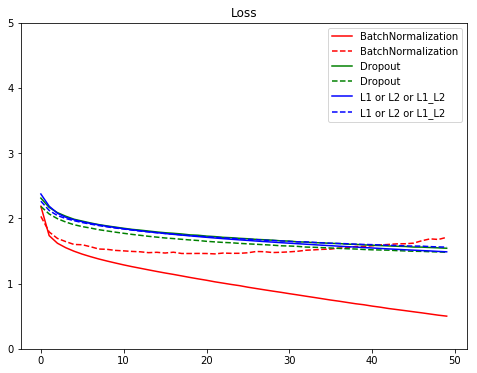

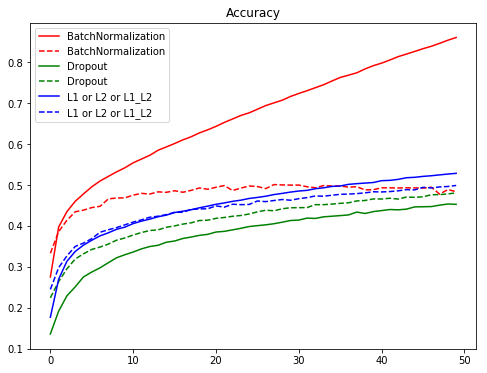

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()